In [2]:
import pandas as pd
import os

data_path = "../data/raw/"
files = os.listdir(data_path)

print("Files found:", files)
print("Total files:", len(files))

dfs = []

for file in files:
    file_path = os.path.join(data_path, file)
    print("Loading:", file)
    df = pd.read_parquet(file_path)
    dfs.append(df)

full_df = pd.concat(dfs, ignore_index=True)

print("\n✅ Final Dataset Shape:", full_df.shape)
full_df.head()



Files found: ['Benign-Monday-no-metadata.parquet', 'Botnet-Friday-no-metadata.parquet', 'Bruteforce-Tuesday-no-metadata.parquet', 'DDoS-Friday-no-metadata.parquet', 'DoS-Wednesday-no-metadata.parquet', 'Infiltration-Thursday-no-metadata.parquet', 'Portscan-Friday-no-metadata.parquet', 'WebAttacks-Thursday-no-metadata.parquet']
Total files: 8
Loading: Benign-Monday-no-metadata.parquet
Loading: Botnet-Friday-no-metadata.parquet
Loading: Bruteforce-Tuesday-no-metadata.parquet
Loading: DDoS-Friday-no-metadata.parquet
Loading: DoS-Wednesday-no-metadata.parquet
Loading: Infiltration-Thursday-no-metadata.parquet
Loading: Portscan-Friday-no-metadata.parquet
Loading: WebAttacks-Thursday-no-metadata.parquet

✅ Final Dataset Shape: (2313810, 78)


,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,6,4,2,0,12,0,6,6,6.00000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
1,6,1,2,0,12,0,6,6,6.00000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
2,6,3,2,0,12,0,6,6,6.00000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
3,6,1,2,0,12,0,6,6,6.00000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
4,6,609,7,4,484,414,233,0,69.14286,111.967896,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign


In [ ]:
# Clean column names
full_df.columns = full_df.columns.str.strip()

print("Cleaned column names sample:")
print(full_df.columns[:10])


In [ ]:
import numpy as np

# Count missing values
missing = full_df.isnull().sum().sum()
print("Total missing values:", missing)

# Count infinite values
inf_count = np.isinf(full_df.select_dtypes(include=[np.number])).sum().sum()
print("Total infinite values:", inf_count)


In [4]:
import numpy as np

# Replace infinite values with NaN
full_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN
before = full_df.shape[0]
full_df.dropna(inplace=True)
after = full_df.shape[0]

print("Rows before cleaning:", before)
print("Rows after cleaning:", after)
print("Rows removed:", before - after)


Rows before cleaning: 2313810
Rows after cleaning: 2313810
Rows removed: 0


In [5]:
# Check unique labels
print("Unique labels:")
print(full_df['Label'].unique())

# Normalize labels (remove spaces)
full_df['Label'] = full_df['Label'].str.strip()

print("\nTop 10 label counts:")
print(full_df['Label'].value_counts().head(10))


Unique labels:
['Benign' 'Bot' 'FTP-Patator' 'SSH-Patator' 'DDoS' 'DoS slowloris'
 'DoS Slowhttptest' 'DoS Hulk' 'DoS GoldenEye' 'Heartbleed' 'Infiltration'
 'PortScan' 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection']

Top 10 label counts:
Label
Benign                      1977318
DoS Hulk                     172846
DDoS                         128014
DoS GoldenEye                 10286
FTP-Patator                    5931
DoS slowloris                  5385
DoS Slowhttptest               5228
SSH-Patator                    3219
PortScan                       1956
Web Attack � Brute Force       1470
Name: count, dtype: int64


In [6]:
# Binary target: 0 = Benign, 1 = Attack
full_df['target'] = full_df['Label'].apply(lambda x: 0 if x == 'Benign' else 1)

print("\nBinary class distribution:")
print(full_df['target'].value_counts())



Binary class distribution:
target
0    1977318
1     336492
Name: count, dtype: int64


In [7]:
# Drop non-feature columns
X = full_df.drop(columns=['Label', 'target'])
y = full_df['target']

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)


Feature matrix shape: (2313810, 77)
Target vector shape: (2313810,)


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Training samples:", X_train.shape)
print("Testing samples:", X_test.shape)


Training samples: (1851048, 77)
Testing samples: (462762, 77)


In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaled training shape:", X_train_scaled.shape)
print("Scaled testing shape:", X_test_scaled.shape)


Scaled training shape: (1851048, 77)
Scaled testing shape: (462762, 77)


In [10]:
import numpy as np

# Subsample for faster training (10% of training data)
subset_size = 200000

indices = np.random.choice(len(X_train_scaled), subset_size, replace=False)

X_train_sub = X_train_scaled[indices]
y_train_sub = y_train.iloc[indices]

print("Subset shape:", X_train_sub.shape)
print("Subset label distribution:")
print(y_train_sub.value_counts())


Subset shape: (200000, 77)
Subset label distribution:
target
0    170489
1     29511
Name: count, dtype: int64


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

rf_model = RandomForestClassifier(
    n_estimators=150,
    max_depth=None,
    n_jobs=-1,
    class_weight='balanced',   # handles imbalance
    random_state=42
)

print("🚀 Training Random Forest...")
rf_model.fit(X_train_sub, y_train_sub)

print("✅ Training completed!")


🚀 Training Random Forest...
✅ Training completed!


In [12]:
print("📈 Evaluating model...")

y_pred = rf_model.predict(X_test_scaled)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


📈 Evaluating model...

Confusion Matrix:
[[395234    230]
 [   544  66754]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    395464
           1       1.00      0.99      0.99     67298

    accuracy                           1.00    462762
   macro avg       1.00      1.00      1.00    462762
weighted avg       1.00      1.00      1.00    462762



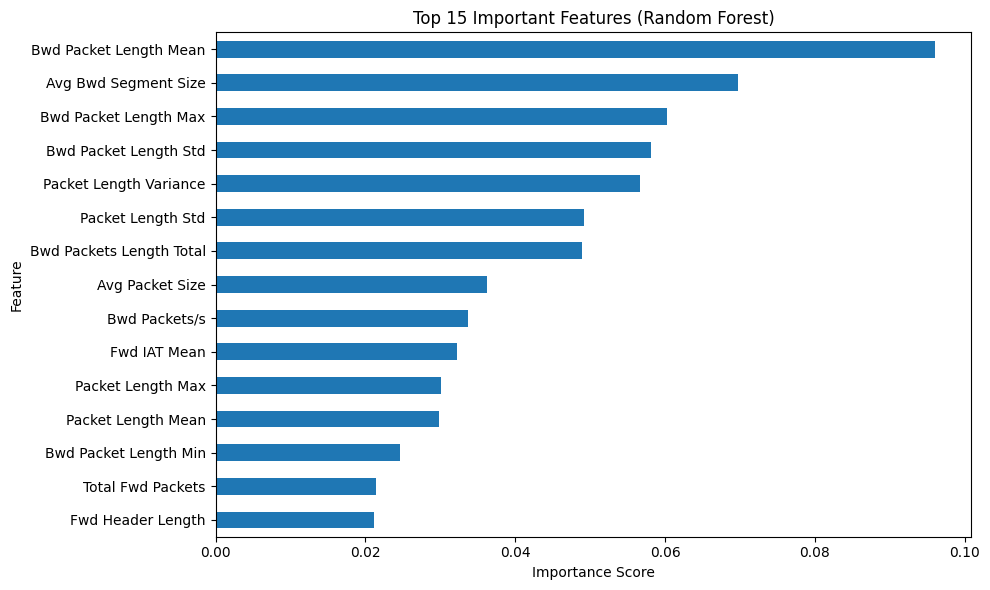

Bwd Packet Length Mean      0.096075
Avg Bwd Segment Size        0.069727
Bwd Packet Length Max       0.060214
Bwd Packet Length Std       0.058105
Packet Length Variance      0.056712
Packet Length Std           0.049189
Bwd Packets Length Total    0.048869
Avg Packet Size             0.036202
Bwd Packets/s               0.033632
Fwd IAT Mean                0.032279
Packet Length Max           0.030103
Packet Length Mean          0.029808
Bwd Packet Length Min       0.024607
Total Fwd Packets           0.021467
Fwd Header Length           0.021161
dtype: float64

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance
importances = rf_model.feature_importances_
feature_names = X.columns

feat_importance = pd.Series(importances, index=feature_names)
top_features = feat_importance.sort_values(ascending=False).head(15)

# Plot
plt.figure(figsize=(10,6))
top_features.plot(kind='barh')
plt.title("Top 15 Important Features (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

top_features


In [14]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    tree_method='hist',
    n_jobs=-1,
    random_state=42
)

print("🚀 Training XGBoost...")
xgb_model.fit(X_train_sub, y_train_sub)

print("✅ XGBoost training completed!")


🚀 Training XGBoost...
✅ XGBoost training completed!


In [15]:
print("📈 Evaluating XGBoost...")

y_pred_xgb = xgb_model.predict(X_test_scaled)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))


📈 Evaluating XGBoost...

Confusion Matrix:
[[395256    208]
 [   283  67015]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    395464
           1       1.00      1.00      1.00     67298

    accuracy                           1.00    462762
   macro avg       1.00      1.00      1.00    462762
weighted avg       1.00      1.00      1.00    462762



In [16]:
import shap
import numpy as np

# Take small sample for SHAP (1000 samples)
sample_idx = np.random.choice(len(X_train_sub), 1000, replace=False)
X_shap = X_train_sub[sample_idx]

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_shap)

print("SHAP values calculated.")


SHAP values calculated.


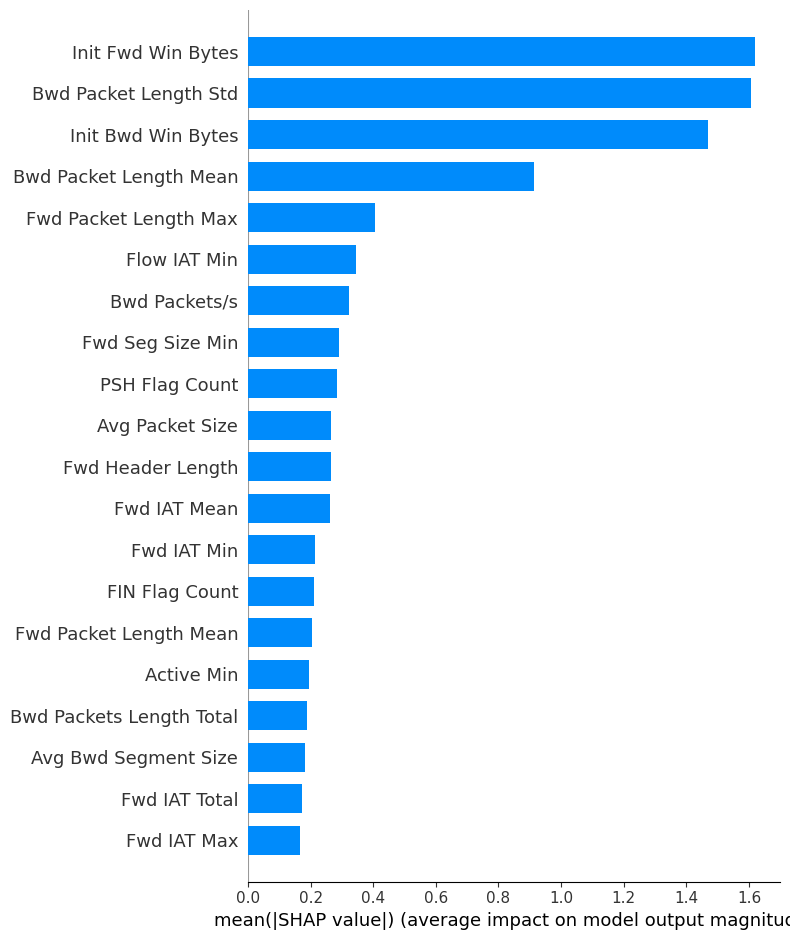

In [17]:
shap.summary_plot(
    shap_values,
    X_shap,
    feature_names=X.columns,
    plot_type="bar"
)


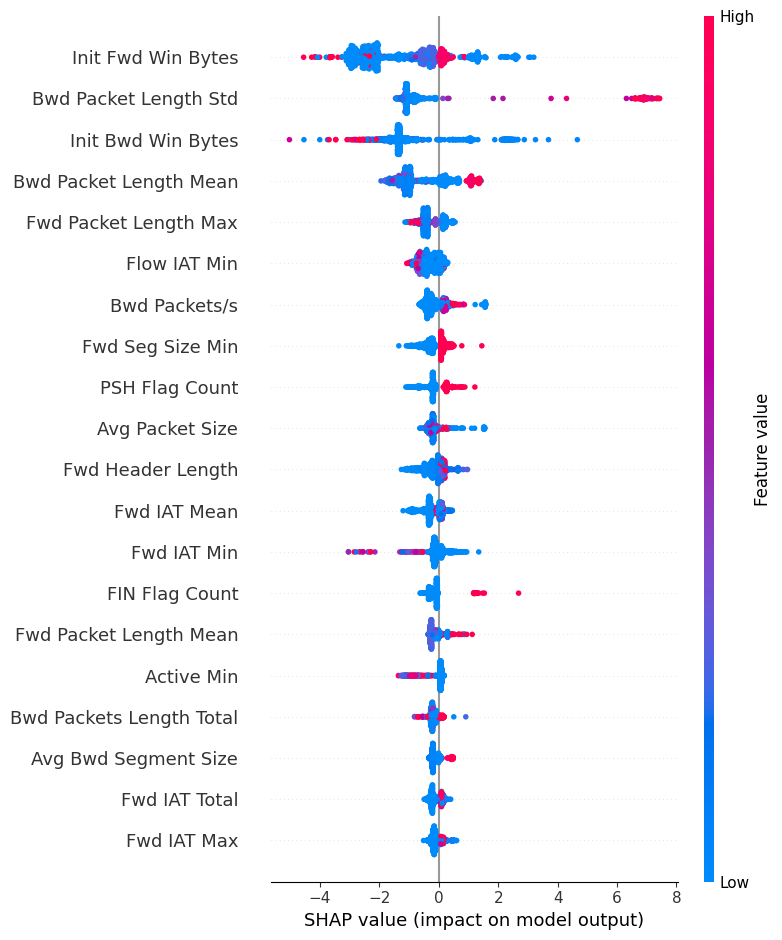

In [18]:
shap.summary_plot(
    shap_values,
    X_shap,
    feature_names=X.columns
)


In [19]:
import joblib
import os

os.makedirs("../models", exist_ok=True)

# Save models
joblib.dump(rf_model, "../models/random_forest.pkl")
joblib.dump(xgb_model, "../models/xgboost.pkl")
joblib.dump(scaler, "../models/scaler.pkl")

print("✅ Models saved successfully!")


✅ Models saved successfully!


In [20]:
import os

os.makedirs("../results/plots", exist_ok=True)
os.makedirs("../results/metrics", exist_ok=True)

# Example: save feature importance plot
plt.savefig("../results/plots/rf_feature_importance.png")

# Save classification report
with open("../results/metrics/xgb_report.txt", "w") as f:
    f.write(classification_report(y_test, y_pred_xgb))

print("✅ Results saved.")


✅ Results saved.


<Figure size 640x480 with 0 Axes>